In [1]:
from interarray.importer import load_repository
from interarray.svg import svgplot
from interarray.mesh import make_planar_embedding
from interarray.interarraylib import G_from_S
from interarray.heuristics import EW_presolver
from interarray.pathfinding import PathFinder
from interarray.MILP import pyomo as omo

In [2]:
from pyomo import environ as pyo

## Initialize MILP solver

In [3]:
from pyomo.contrib.appsi.solvers import Highs

In [4]:
highser = pyo.SolverFactory('appsi_highs')
highser.available(), type(highser)

(True,
 pyomo.contrib.appsi.base.SolverFactoryClass.register.<locals>.decorator.<locals>.LegacySolver)

## Load interarray's locations

In [5]:
locations = load_repository()

## Optimize Triton

In [6]:
L = locations.triton
capacity = 8

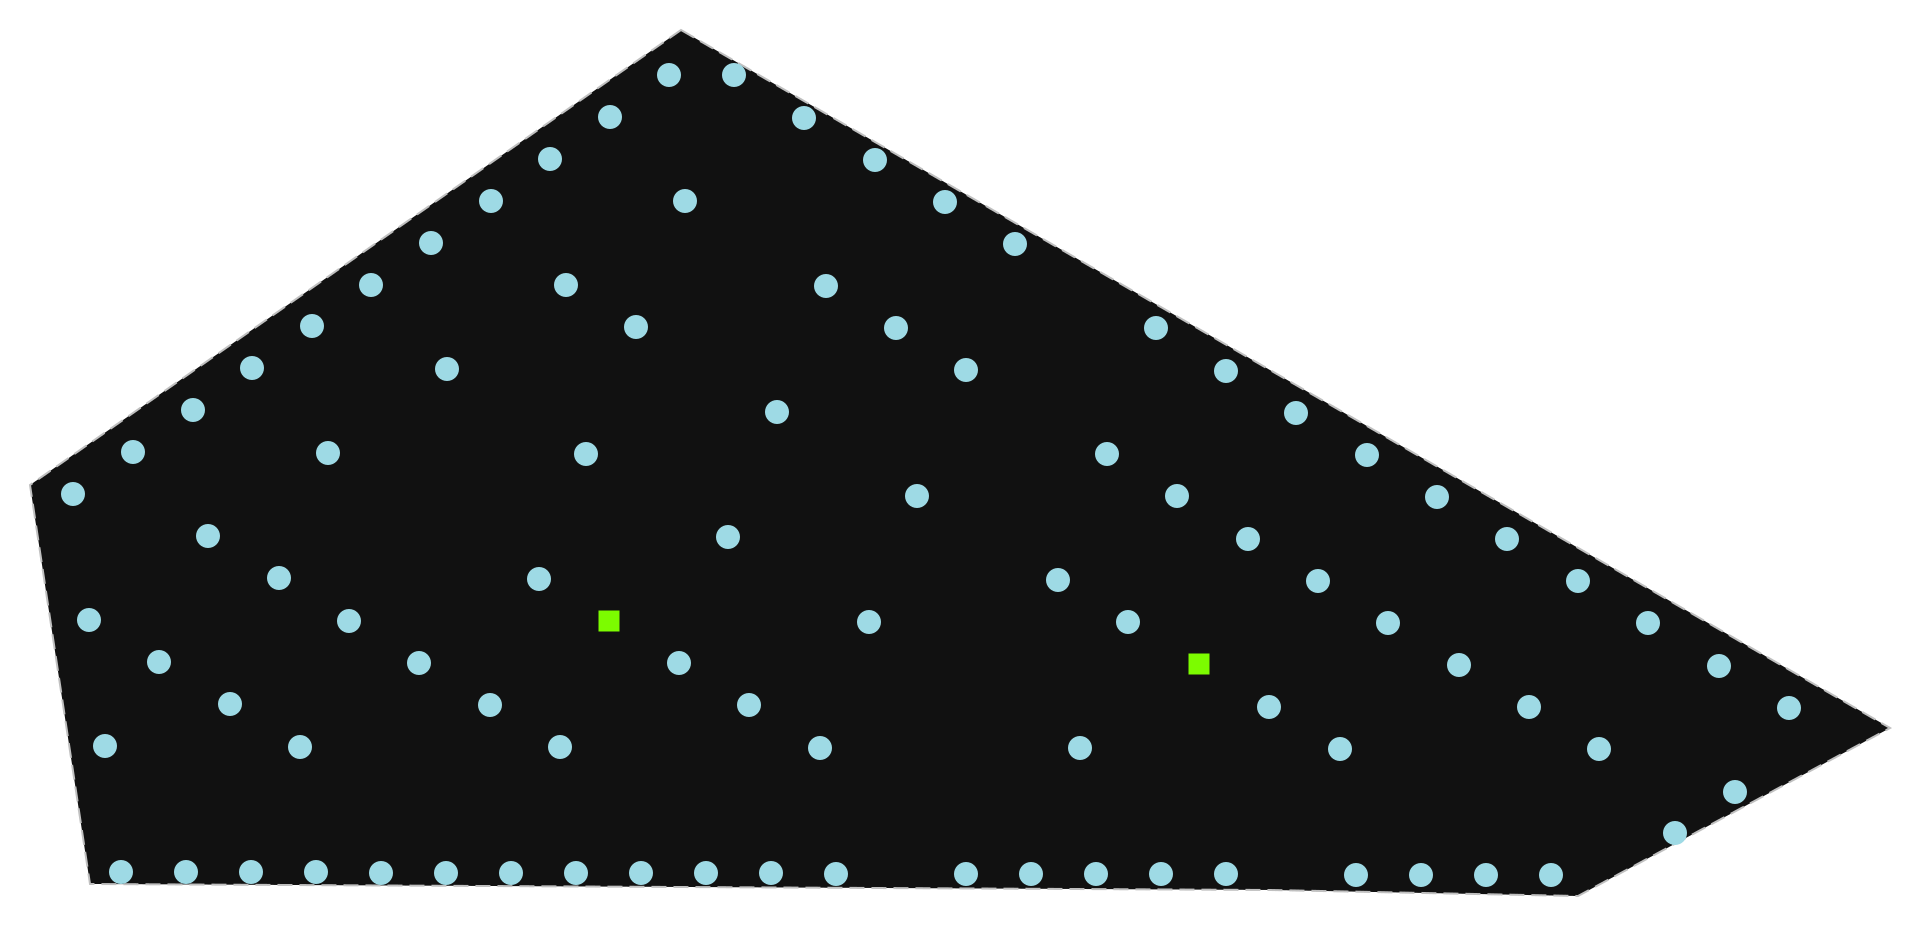

In [7]:
svgplot(L)

In [8]:
P, A = make_planar_embedding(L)

Initial heuristic solution to warm-start the solver:

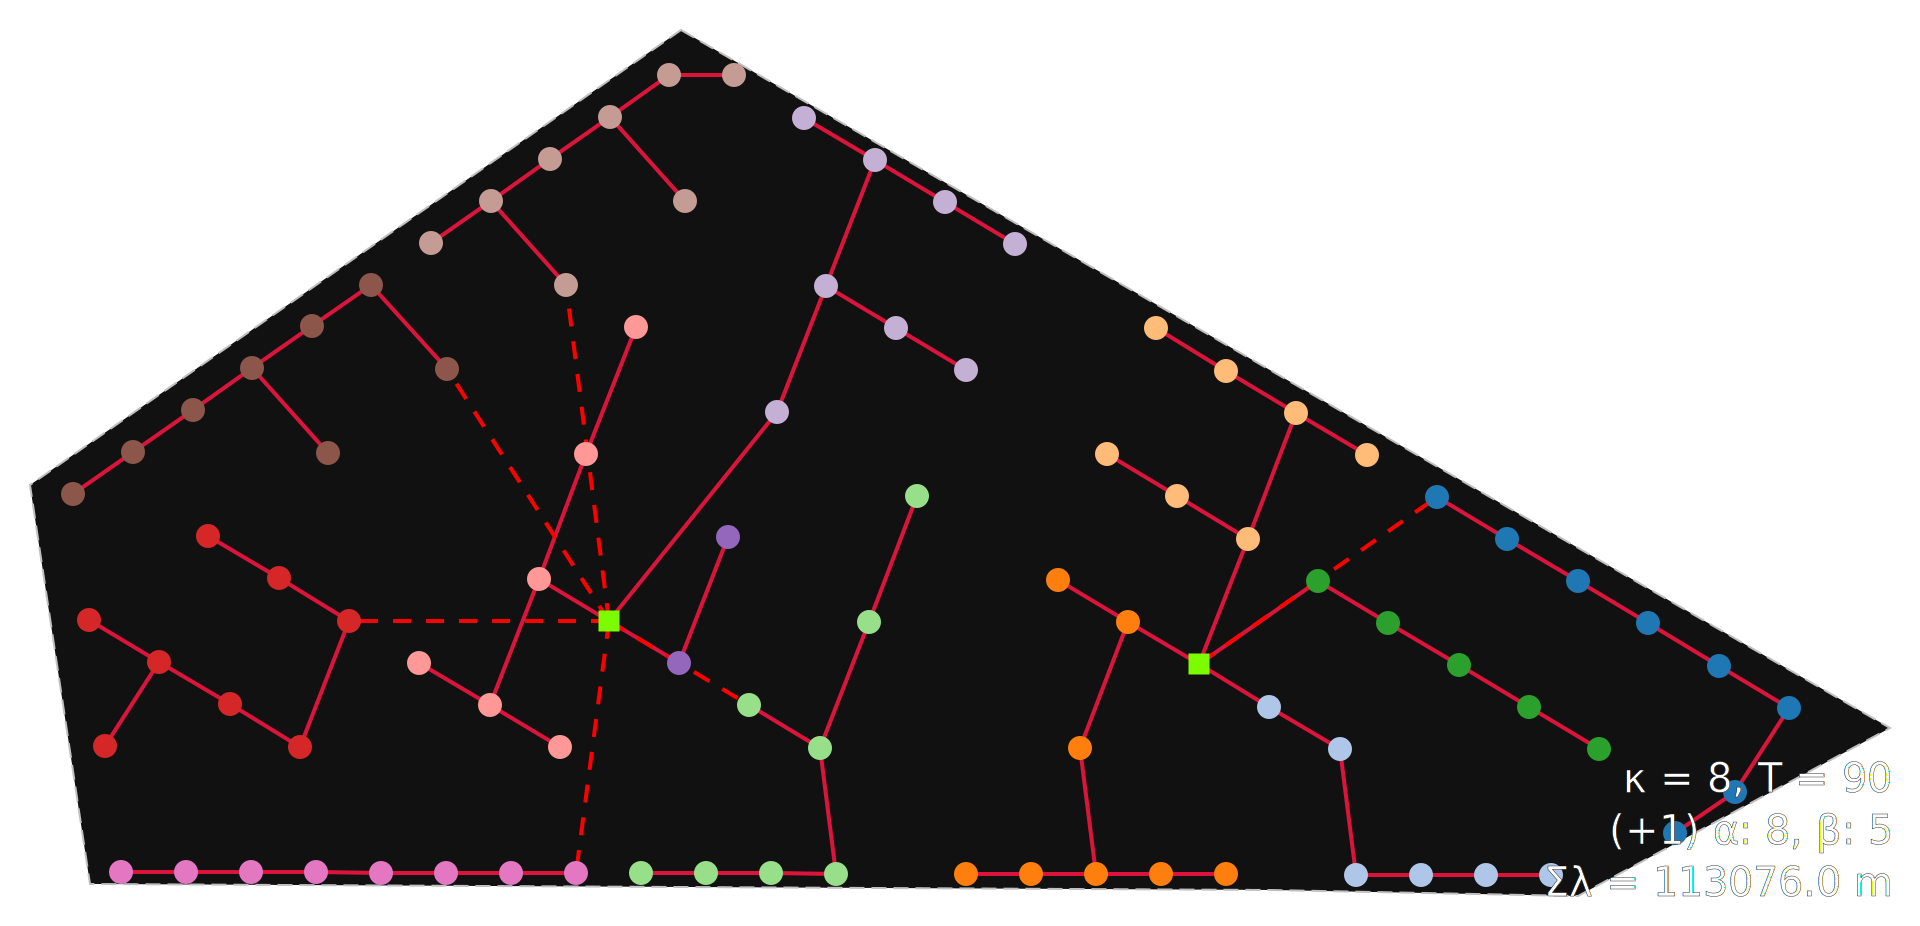

In [9]:
Sʹ = EW_presolver(A, capacity=capacity)
Gʹ = G_from_S(Sʹ, A)
svgplot(Gʹ)

In [10]:
model = omo.make_min_length_model(
    A, capacity,
    gateXings_constraint=False,
    branching=True,
    gates_limit=False
)
omo.warmup_model(model, Sʹ);

In [11]:
# not sure if this one is the correct one
# highser = pyo.SolverFactory('appsi_highs')
highser.options.update(dict(
    time_limit=60,  # timelimit?
    mip_rel_gap=0.005,  # mipgap?
))
print(f'Solving "{model.handle}": {{R={len(model.R)}, T={len(model.T)}, k={model.k.value}}}\n')
result = highser.solve(model, tee=True)

Solving "triton": {R=2, T=90, k=8}

Running HiGHS 1.9.0 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
RUN!
Coefficient ranges:
  Matrix [1e+00, 8e+00]
  Cost   [8e+02, 1e+04]
  Bound  [1e+00, 8e+00]
  RHS    [1e+00, 9e+01]
Presolving model
2708 rows, 1764 cols, 9840 nonzeros  0s
2344 rows, 1722 cols, 8788 nonzeros  0s

Solving MIP model with:
   2344 rows
   1722 cols (842 binary, 880 integer, 0 implied int., 0 continuous)
   8788 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0 

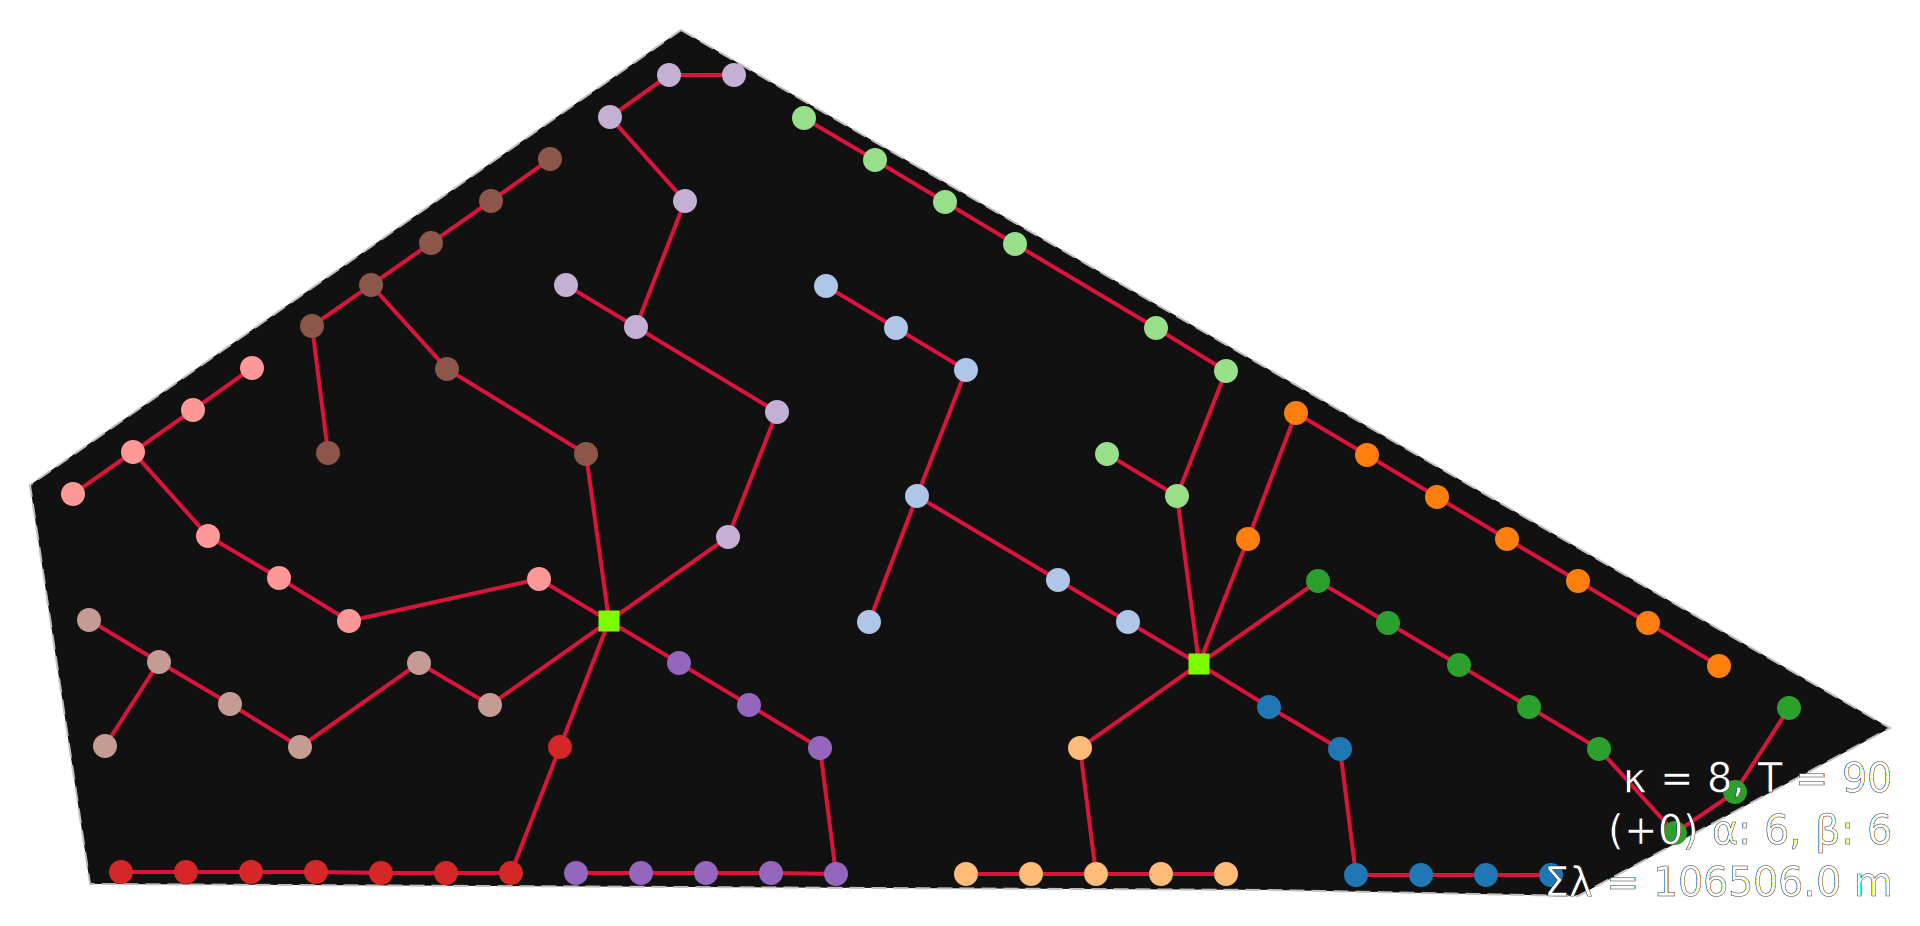

In [12]:
S = omo.S_from_solution(model, highser, result)
G = G_from_S(S, A)
H = PathFinder(G, planar=P, A=A).create_detours()
svgplot(H)